# Kaggle competition - sales forecast (score = 0.4739)

# Introduction

The topic of the notes is a time scale. When forecasting time series one of the questions is how to chose time period for fitting a model. Usually it is a trade off between the need to keep enough data to build the model and the attempt to avoid irrelevant old data. This choice is due to the obvious fact that things change with time. For example new store can be open, another shope can stop trading some goods family  or the demend for some goods can dramatically increase without connection with the features we have in dataset. We will use only linear regressions.

The logic of the note is:\
    1. data preporation, nothing special\
    2. dividing the train_dataset for train and validation parts.\
    3. building a function metric = metric(number of days for fitting), metric is culculated on validation dataset.\
    4. building a model for full train dataset and prediction for test dataset.\
    5. study the function metric = metric(number of days for fitting) in attemps to inprove solution.
    6. looking at sales figures for better undestanding forecast limitation.

# Import

In [1]:
import time

In [2]:
time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())

'2024-05-04 18:53:20'

In [3]:
import os

In [4]:
os.getcwd()

'C:\\Users\\as271\\ml_study\\tensor_flow\\sales_time_series'

In [5]:
import sys

In [6]:
print(sys.executable)

C:\Users\as271\anaconda3\python.exe


In [7]:
import numpy as np

In [8]:
import pandas as pd

In [9]:
from datetime import date
from datetime import timedelta
from datetime import datetime

In [10]:
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute        import SimpleImputer
from sklearn.impute        import KNNImputer
from sklearn.compose       import ColumnTransformer
from sklearn.linear_model  import LinearRegression
from sklearn.metrics       import mean_squared_log_error
from sklearn.preprocessing import StandardScaler

In [11]:
import matplotlib.pyplot as plt
import seaborn           as sns
import matplotlib.dates  as mdates

In [12]:
from statsmodels.tsa.deterministic import DeterministicProcess

In [13]:
def to_plus(pred):
    pred_plus = []
    for s in pred:
        if s > 0: plus = s
        else:     plus = 0
        pred_plus.append(plus)
    return pred_plus

# Read data 

For linear regression we will use limited number of features, still we prefer to download all available data, to have opportunity to analysis any available features

In [14]:
#read_data
holidays_events_data   = pd.read_csv("data/holidays_events.csv"  ,parse_dates=['date'], infer_datetime_format=True)
stores_data            = pd.read_csv("data/stores.csv"                                                            )
transactions_data      = pd.read_csv("data/transactions.csv"     ,parse_dates=['date'], infer_datetime_format=True)
test_data              = pd.read_csv("data/test.csv"             ,parse_dates=['date'], infer_datetime_format=True)
oil_data               = pd.read_csv("data/oil.csv"              ,parse_dates=['date'], infer_datetime_format=True)
train_data             = pd.read_csv("data/train.csv"            ,parse_dates=['date'], infer_datetime_format=True)
sample_submission_data = pd.read_csv("data/sample_submission.csv"                                                 )    

In [15]:
# names for df
holidays_events_data.name   = 'holidays_events_data'
oil_data.name               = 'oil_data'
sample_submission_data.name = 'sample_submission_data'
stores_data.name            = 'stores_data'
transactions_data.name      = 'transactions_data'
test_data.name              = 'test_data'
train_data.name             = 'train_data'

In [16]:
# format dates
# we will use "pandas._libs.tslibs.period.Period" type, as we don't need hours, etc.
holidays_events_data['date'] = holidays_events_data['date'].dt.to_period('D') 
oil_data['date']             = oil_data['date']            .dt.to_period('D')                   
transactions_data['date']    = transactions_data['date']   .dt.to_period('D')    
test_data['date']            = test_data['date']           .dt.to_period('D')              
train_data['date']           = train_data['date']          .dt.to_period('D')            

In [17]:
type(holidays_events_data['date'][0])

pandas._libs.tslibs.period.Period

# Look at the data

In this section we have a glance on the data

In [18]:
train_data.iloc[:3,:]

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0


In [19]:
train_data.iloc[-3:,:]

,id,date,store_nbr,family,sales,onpromotion
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8
3000887,3000887,2017-08-15,9,SEAFOOD,16.000,0


In [20]:
#Check for Nan
if ( train_data.isna().sum().sum()+test_data.isna().sum().sum() )== 0: print('There in no NaN in train and test sets')

There in no NaN in train and test sets


In [21]:
# No NaN in train and test

In [22]:
# How many lines?
train_data.shape,test_data.shape

((3000888, 6), (28512, 5))

In [23]:
# How many date we have?
train_data.date.unique().shape, test_data.date.unique().shape 

((1684,), (16,))

In [24]:
test_data.head(3)

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2


In [25]:
test_date = test_data.date.unique()
test_date

<PeriodArray>
['2017-08-16', '2017-08-17', '2017-08-18', '2017-08-19', '2017-08-20',
 '2017-08-21', '2017-08-22', '2017-08-23', '2017-08-24', '2017-08-25',
 '2017-08-26', '2017-08-27', '2017-08-28', '2017-08-29', '2017-08-30',
 '2017-08-31']
Length: 16, dtype: period[D]

In [26]:
test_data.onpromotion.value_counts()

0      15943
1       2542
2       1102
3        648
10       557
       ...  
135        1
148        1
171        1
206        1
592        1
Name: onpromotion, Length: 212, dtype: int64

In [27]:
# promotions are present in test data

In [28]:
holidays_events_data.head(3)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False


In [29]:
print(f"holidays types:\n\n{holidays_events_data.locale.value_counts()}\
        \n\ntotal ammount days with holidays: {holidays_events_data.date.unique().shape[0]}\
        \ndays total: {train_data.date.unique().shape[0]}\
        \nin persents: {int(holidays_events_data.date.unique().shape[0]/train_data.date.unique().shape[0]*100)}%")

holidays types:

National    174
Local       152
Regional     24
Name: locale, dtype: int64        

total ammount days with holidays: 312        
days total: 1684        
in persents: 18%


In [30]:
holidays_in_test = holidays_events_data.loc[holidays_events_data.date.isin(test_date)]
print('How many holidays do we have in test period?')
holidays_in_test

How many holidays do we have in test period?


,date,type,locale,locale_name,description,transferred
327,2017-08-24,Holiday,Local,Ambato,Fundacion de Ambato,False


In [31]:
# further we will use validation the same length as test length
delta_d = timedelta(test_date.shape[0])
v_date = [d - delta_d  for d in test_date]
holidays_in_v = holidays_events_data.loc[holidays_events_data.date.isin(v_date)]
print('How many holidays do we have in validation period?')
holidays_in_v

How many holidays do we have in validation period?


,date,type,locale,locale_name,description,transferred
323,2017-08-05,Holiday,Local,Esmeraldas,Fundacion de Esmeraldas,False
324,2017-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,True
325,2017-08-11,Transfer,National,Ecuador,Traslado Primer Grito de Independencia,False
326,2017-08-15,Holiday,Local,Riobamba,Fundacion de Riobamba,False


Conclusion about holidays:
1. so only one local holiday during test period
2. 18% of holiday in train
3. during supposed validation period there are 4 holidays including 2 national

In [32]:
stores_data.head(5)

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [33]:
stores_data.state.unique()

array(['Pichincha', 'Santo Domingo de los Tsachilas', 'Cotopaxi',
       'Chimborazo', 'Imbabura', 'Bolivar', 'Pastaza', 'Tungurahua',
       'Guayas', 'Santa Elena', 'Los Rios', 'Azuay', 'Loja', 'El Oro',
       'Esmeraldas', 'Manabi'], dtype=object)

In [34]:
transactions_data.head(3)

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358


In [35]:
transactions_data.loc[transactions_data.date.isin(test_date)]

,date,store_nbr,transactions


In [36]:
# no data about transaction for test period

In [37]:
# How many lines?
train_data.shape,test_data.shape

((3000888, 6), (28512, 5))

In [38]:
print(f'How many dates are in train and test data?\n\ntrain dates: {len(train_data.date.unique())}\ntest dates:    {len(test_data.date.unique())}')

How many dates are in train and test data?

train dates: 1684
test dates:    16


In [39]:
oil_data.head(3)

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97


In [40]:
oil_data.loc[oil_data.date.isin(test_date)]

,date,dcoilwtico
1206,2017-08-16,46.80
1207,2017-08-17,47.07
1208,2017-08-18,48.59
1209,2017-08-21,47.39
1210,2017-08-22,47.65
1211,2017-08-23,48.45
1212,2017-08-24,47.24
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46


So we have oil prices for test period :)

First Conclusion: 
1. No NaN in train and test
2. 1600 + dates are in train, 16 dates are in test
3. no data for test in transactions_data
4. one local holiday is during test period, 4 holidays for validation period
5. deeper look in data will be below in preparation section

# Data preprocessing

In [41]:
train_data.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [42]:
test_data.isna().sum()

id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64

In [43]:
holidays_dates       = holidays_events_data.date.unique().tolist()
train_dates          = train_data.date.unique().tolist()
test_dates           = test_data.date.unique() .tolist()
n_train              = len(train_dates)
n_test               = len(test_dates)
train_working_dates = [item for item in train_dates if item not in holidays_dates]
train_holiday_dates = [item for item in train_dates if item     in holidays_dates]
test_working_dates  = [item for item in test_dates  if item not in holidays_dates]
test_holiday_dates  = [item for item in test_dates  if item     in holidays_dates]

print(f'Number of unique dates:\n\
        \n train:             {n_train}\
        \n      working       {len(train_working_dates)}\
        \n      holidays      {len(train_holiday_dates)}\
        \n test:              {n_test}\
        \n\
        \n      working       {len(test_working_dates)}\
        \n      holiday       {len(test_holiday_dates)}\
        \n\
        \n holidays           {len(holidays_dates)}  ')

Number of unique dates:
        
 train:             1684        
      working       1432        
      holidays      252        
 test:              16        
        
      working       15        
      holiday       1        
        
 holidays           312  


We have only one local holiday for test set and a lot of question how to include holiday information into the model. Conclusion: to delate holidays data.

In [44]:
# DELETE HOLIDAYS FROM train_data !!!!!!
#train_data = train_data.loc[train_data.date.isin(train_working_dates)]
train_data.shape

(3000888, 6)

In [45]:
mistake = [item for item in test_working_dates if  item in holidays_dates]
mistake 

[]

In [46]:
mistake = [item for item in holidays_dates if  (item not in train_dates )]
len(mistake ), mistake[0:5]

(60,
 [Period('2012-03-02', 'D'),
  Period('2012-04-01', 'D'),
  Period('2012-04-12', 'D'),
  Period('2012-04-14', 'D'),
  Period('2012-04-21', 'D')])

In [47]:
train_dates[0:5]

[Period('2013-01-01', 'D'),
 Period('2013-01-02', 'D'),
 Period('2013-01-03', 'D'),
 Period('2013-01-04', 'D'),
 Period('2013-01-05', 'D')]

In [48]:
# so holidayes are given for times before train dates (59 dates + 1 dates for test)

# Fix numbers for train, test, val

In [49]:
N_train_dates = train_data.date.unique().shape[0]
N_test_dates = test_data.date.unique().shape[0]
# put val size the same (dates) as test size (dates)
N_val_dates   = N_test_dates 
N_tr_dates    = N_train_dates - N_val_dates
#dates
date_train  = train_data.date.unique()
date_tr     = date_train[:N_tr_dates]
date_val    = date_train[N_tr_dates:]
date_test   = test_data.date.unique()

#print(date_train.shape, date_val.shape)
# number of lines for initial format
N_train_data = train_data.shape[0]
N_test_data  = test_data.shape[0]
N_val        = train_data.loc[train_data.date.isin(date_val)].shape[0]
N_tr         = N_train_data - N_val

# get id and dates for train, val, test
# id
train_id = train_data.iloc[:N_tr].id
val_id   = train_data.iloc[N_tr:].id
test_id  = test_data.id

print(f'Number of lines\
        \ntrain set: {N_train_data}, test set: {N_test_data}\
        \ntrain set: {N_train_data}  = train: {N_tr} + val: {N_val}\
        \n\nNumber of dates\
        \ntrain set dates: {N_train_dates}, test dates: {N_test_dates}\
        \ntrain set dates: {N_train_dates}  = train set: {N_tr_dates} + val dates: {N_val_dates}')

Number of lines        
train set: 3000888, test set: 28512        
train set: 3000888  = train: 2972376 + val: 28512        

Number of dates        
train set dates: 1684, test dates: 16        
train set dates: 1684  = train set: 1668 + val dates: 16


In [50]:
# Check how many holidays are in validtion set.
val_dates = list(set(train_data.date.loc[val_id]))
val_hoilidays = [d for d in holidays_dates if d in val_dates]
val_hoilidays
holidays_events_data.loc[holidays_events_data.date.isin(val_hoilidays)]

,date,type,locale,locale_name,description,transferred
323,2017-08-05,Holiday,Local,Esmeraldas,Fundacion de Esmeraldas,False
324,2017-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,True
325,2017-08-11,Transfer,National,Ecuador,Traslado Primer Grito de Independencia,False
326,2017-08-15,Holiday,Local,Riobamba,Fundacion de Riobamba,False


In [51]:
# concat train and test
train_plus_test = pd.concat([train_data,test_data], axis = 0)
train_plus_test.reset_index(inplace  = True, drop = True)
train_plus_test.head(3)

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0


In [52]:
#check for Nan
train_plus_test.isna().sum()

id                 0
date               0
store_nbr          0
family             0
sales          28512
onpromotion        0
dtype: int64

In [53]:
# as we do not have test.sales, there are Nan in train_plus_test.sales, so replace Nan for 0,  to avoid Nan in dataset
train_plus_test.fillna(0, inplace = True)

In [54]:
train_plus_test.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [55]:
# check that the shapes are correct
train_plus_test.shape, train_data.shape, test_data.shape, train_data.shape[0] + test_data.shape[0]

((3029400, 6), (3000888, 6), (28512, 5), 3029400)

In [56]:
# on the first step keep only National holidayes
holidays_national = holidays_events_data[holidays_events_data.locale == 'National']
holidays_national = holidays_national[~holidays_national['date'].duplicated(keep = 'first')]
len(holidays_national.date.unique()), np.sum(holidays_national['date'].duplicated(keep = 'first'))

(168, 0)

In [57]:
# merge all dataset to one
print('look at the shape after every step, to be sure that merge is correct')
train_plus_test_plus = pd.merge(train_plus_test      ,stores_data         , on = ['store_nbr'],         how = 'left')
print('1',train_plus_test_plus.shape)
train_plus_test_plus = pd.merge(train_plus_test_plus ,transactions_data   , on = ['date', 'store_nbr'], how = 'left')
print('2',train_plus_test_plus.shape)
# attention
train_plus_test_plus = pd.merge(train_plus_test_plus ,holidays_national   , on = ['date'],              how = 'left')
print('3',train_plus_test_plus.shape)
train_plus_test_plus = pd.merge(train_plus_test_plus ,oil_data            , on = ['date'],              how = 'left')
print('4',train_plus_test_plus.shape)
train_plus_test_plus.head(3)

look at the shape after every step, to be sure that merge is correct
1 (3029400, 10)
2 (3029400, 11)
3 (3029400, 16)
4 (3029400, 17)


,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,transactions,type_y,locale,locale_name,description,transferred,dcoilwtico
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN


In [58]:
holidays = train_plus_test_plus.locale.fillna('no').to_frame()
holidays.value_counts()
holidays_01 = holidays.applymap(lambda x : 0 if x == 'no' else 1)

In [59]:
holidays.value_counts(), holidays_01.value_counts(), holidays_01.index

(locale  
 no          2774574
 National     254826
 dtype: int64,
 locale
 0         2774574
 1          254826
 dtype: int64,
 Int64Index([      0,       1,       2,       3,       4,       5,       6,
                   7,       8,       9,
             ...
             3029390, 3029391, 3029392, 3029393, 3029394, 3029395, 3029396,
             3029397, 3029398, 3029399],
            dtype='int64', length=3029400))

In [60]:
y = train_plus_test_plus['date'].apply(lambda x: x.to_timestamp())

In [61]:
start_day = train_plus_test_plus.loc[0,'date'].to_timestamp()

In [62]:
(y- start_day).dt.days

0             0
1             0
2             0
3             0
4             0
           ... 
3029395    1703
3029396    1703
3029397    1703
3029398    1703
3029399    1703
Name: date, Length: 3029400, dtype: int64

In [63]:
# add data feature
def workout_data(df_in,start_day):
    df = df_in.copy()
    #df['date']       = pd.to_datetime(df['date'])
    d_series         = df['date'].apply(lambda x: x.to_timestamp())
    df['daynumber']  = (d_series- start_day).dt.days
    df['dayofweek']  = d_series.dt.dayofweek
    df['quarter']    = d_series.dt.quarter
    df['month']      = d_series.dt.month
    df['year']       = d_series.dt.year
    df['dayofyear']  = d_series.dt.dayofyear
    df['dayofmonth'] = d_series.dt.day
    #df = df.drop('date', axis=1, inplace=False)
    return df

In [64]:
# add data feature
#start_day = pd.to_datetime(train_plus_test_plus.loc[0,'date'])
start_day = train_plus_test_plus.loc[0,'date'].to_timestamp()
print(start_day)
train_plus_test_plus = workout_data(train_plus_test_plus,start_day)

2013-01-01 00:00:00


In [65]:
train_plus_test_plus.shape

(3029400, 24)

In [66]:
train_plus_test_plus.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city',
       'state', 'type_x', 'cluster', 'transactions', 'type_y', 'locale',
       'locale_name', 'description', 'transferred', 'dcoilwtico', 'daynumber',
       'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth'],
      dtype='object')

In [67]:
# check for null and type
dtypes       = train_plus_test_plus.dtypes
data_list    = dtypes.index.tolist()

# indexes of different data types
object_list  = dtypes.index[dtypes == 'object' ].tolist()
int_list     = dtypes.index[dtypes == 'int64'  ].tolist()
float_list   = dtypes.index[dtypes == 'float64'].tolist()
isn          = np.sum(train_plus_test_plus.isnull())
ins_percent  = np.sum(train_plus_test_plus.isnull())/train_plus_test_plus.shape[0]*100

types_null_encoding_info = pd.DataFrame({'dtypes'      :dtypes.values,
                                         'isn'         :isn.values,
                                         'ins_percent' :ins_percent.values},
                                         index = data_list)
# add amount of unique values
types_null_encoding_info.loc[:,'unique_n'] = 0
for col in types_null_encoding_info.index:
  if types_null_encoding_info.loc[col,'dtypes'] != 'float64':
     unique_values = train_plus_test_plus[col].unique()
     n_unique_values = len(unique_values)
     types_null_encoding_info.loc[col,'unique_n'] = n_unique_values

# add column with fiture type
types_null_encoding_info['feature_type'] = 'cat'
types_null_encoding_info.loc['daynumber'   ,'feature_type' ] = 'num'
types_null_encoding_info.loc['transactions','feature_type' ] = 'num'
types_null_encoding_info.loc['dcoilwtico'  ,'feature_type' ] = 'num'
order_features_list = ['quarter','month','year','dayofyear','dayofmonth']
types_null_encoding_info.loc[order_features_list,'feature_type'] = 'order'
 
#types_null_encoding_info.sort_values('dtypes', inplace = True)
#types_null_encoding_info

In [68]:
# form lists 
# to drop
list_feature_to_drop     = ['year',
                            'daynumber',
                            'state',
                            'transactions']
#,'city']
#'daynumber',
#'dayofmonth',
#'dayofyear',]
list_to_drop_later       = ['id',
                            'date',
                            'sales']
#,'month']
# Nan
list_null_to_previous    = ['dcoilwtico']
list_null_to_zero        = []
list_null_to_mean        = []

# Encoding
list_of_float            = ['dcoilwtico']
list_of_label_encoding   = ['quarter',  ]                            
list_onehotencoding      = ['store_nbr',
                            'family', 
                            'onpromotion',
                            'type',
                            'cluster',
                            'dayofweek',
                            'city']

In [69]:
# check if all features are in lists

list_columns_totall = types_null_encoding_info.index.to_list()
merged_list         = list_feature_to_drop + list_of_label_encoding + list_onehotencoding + list_of_float + list_to_drop_later
missed_features     = [el for el in list_columns_totall if el not in merged_list]

if len(missed_features) == 0: print('Ok') 
else                        : print(missed_features) 

['type_x', 'type_y', 'locale', 'locale_name', 'description', 'transferred', 'month', 'dayofyear', 'dayofmonth']


In [70]:
# drop

In [71]:
train_plus_test_plus.shape

(3029400, 24)

In [72]:
train_plus_test_plus.drop(list_feature_to_drop, axis =1, inplace= True)

In [73]:
len (list_feature_to_drop), train_plus_test_plus.shape

(4, (3029400, 20))

In [74]:
# Fill Nan
train_plus_test_plus[list_null_to_zero    ] = train_plus_test_plus[list_null_to_zero    ].fillna('no')
train_plus_test_plus[list_null_to_previous] = train_plus_test_plus[list_null_to_previous].fillna(method = 'ffill')
train_plus_test_plus[list_null_to_previous] = train_plus_test_plus[list_null_to_previous].fillna(method = 'backfill')

In [75]:
train_plus_test_plus['onpromotion'] = train_plus_test_plus['onpromotion'].to_frame().applymap(lambda x: x if x < 7 else 8 )


In [76]:
# check for null
train_plus_test_plus.isnull().sum()

id                   0
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
city                 0
type_x               0
cluster              0
type_y         2774574
locale         2774574
locale_name    2774574
description    2774574
transferred    2774574
dcoilwtico           0
dayofweek            0
quarter              0
month                0
dayofyear            0
dayofmonth           0
dtype: int64

Add avarage (groupby store, family), for day of week and for day of month

In [77]:
for_mean = train_plus_test_plus[train_plus_test_plus.id.isin(train_id)]
for_mean = for_mean.reset_index().set_index('id')

#avr day of week
avarage_week          = for_mean.groupby(['dayofweek','store_nbr','family']).mean('sales')['sales'].reset_index()
avarage_week.columns  = ['dayofweek','store_nbr','family','avr_dayofweek']

#avr month
avarage_month         = for_mean.groupby(['month','store_nbr','family']).mean('sales')['sales'].reset_index()
avarage_month.columns = ['month','store_nbr','family','avr_month']

# avr month
avarage_year         = for_mean.groupby(['dayofyear','store_nbr','family']).mean('sales')['sales'].reset_index()
avarage_year.columns = ['dayofyear','store_nbr','family','avr_dayofyear']

In [78]:
# concat
train_plus_test_plus = pd.merge(train_plus_test_plus, avarage_week,
                                how = 'left',
                                on = ['dayofweek','store_nbr','family'])
#.drop('dayofweek',axis =1)
train_plus_test_plus = pd.merge(train_plus_test_plus, avarage_month, 
                                how = 'left', 
                                on = ['month','store_nbr','family'])
train_plus_test_plus = pd.merge(train_plus_test_plus, avarage_year, 
                                how = 'left', 
                                on = ['dayofyear','store_nbr','family']) 
#.drop('month'    ,axis =1)

In [79]:
train_plus_test_plus.head(3)

,id,date,store_nbr,family,sales,onpromotion,city,type_x,cluster,type_y,...,transferred,dcoilwtico,dayofweek,quarter,month,dayofyear,dayofmonth,avr_dayofweek,avr_month,avr_dayofyear
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,D,13,Holiday,...,False,93.14,1,1,1,1,1,3.866109,3.141935,0.0
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,D,13,Holiday,...,False,93.14,1,1,1,1,1,0.000000,0.000000,0.0
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,D,13,Holiday,...,False,93.14,1,1,1,1,1,2.581590,2.129032,0.0


In [80]:
train_plus_test_plus.isna().sum()

id                     0
date                   0
store_nbr              0
family                 0
sales                  0
onpromotion            0
city                   0
type_x                 0
cluster                0
type_y           2774574
locale           2774574
locale_name      2774574
description      2774574
transferred      2774574
dcoilwtico             0
dayofweek              0
quarter                0
month                  0
dayofyear              0
dayofmonth             0
avr_dayofweek          0
avr_month              0
avr_dayofyear          0
dtype: int64

In [81]:
train_plus_test_plus.shape

(3029400, 23)

In [82]:
train_plus_test_plus.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city',
       'type_x', 'cluster', 'type_y', 'locale', 'locale_name', 'description',
       'transferred', 'dcoilwtico', 'dayofweek', 'quarter', 'month',
       'dayofyear', 'dayofmonth', 'avr_dayofweek', 'avr_month',
       'avr_dayofyear'],
      dtype='object')

In [83]:
train_plus_test_plus.head(3)

,id,date,store_nbr,family,sales,onpromotion,city,type_x,cluster,type_y,...,transferred,dcoilwtico,dayofweek,quarter,month,dayofyear,dayofmonth,avr_dayofweek,avr_month,avr_dayofyear
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,D,13,Holiday,...,False,93.14,1,1,1,1,1,3.866109,3.141935,0.0
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,D,13,Holiday,...,False,93.14,1,1,1,1,1,0.000000,0.000000,0.0
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,D,13,Holiday,...,False,93.14,1,1,1,1,1,2.581590,2.129032,0.0


In [84]:
def get_metric(df,first_columns, second_columns):
    y_first_val    = df.loc[val_id  ,first_columns ].to_frame().applymap (lambda x: x if x> 0 else 0.00001)
    y_second_val   = df.loc[val_id  ,second_columns].to_frame().applymap (lambda x: x if x> 0 else 0.00001)
    rmsle_val      = mean_squared_log_error(y_first_val    , y_second_val   , squared = False)
    return rmsle_val

# Linear regression

prepare date for linear regression

In [85]:
dataset_columns_list        = train_plus_test_plus.columns.to_list()
columns_for_linear_list     = ['id','date','store_nbr','family','sales']
columns_not_for_linear_list = [item for item in dataset_columns_list if item not in columns_for_linear_list  ] 

1. Select data for linear regression

In [86]:
train_plus_test_plus.index = train_plus_test_plus.id

In [87]:
sum(train_plus_test_plus.index.duplicated())

0

In [88]:
data_for_linear            = train_plus_test_plus[columns_for_linear_list    ]
#.reset_index(drop = True)    
data_not_for_linear        = train_plus_test_plus[columns_not_for_linear_list]
#.reset_index(drop = True)

In [89]:
data_for_linear.shape, data_not_for_linear.shape

((3029400, 5), (3029400, 18))

2. Set multi - index

In [90]:
data_for_linear_multiindex = (data_for_linear.set_index(['date','store_nbr','family'])
                                   .sort_index(level =  ['date','store_nbr','family']))

3. Select y and id

In [91]:
y_for_linear_multiindex    = (data_for_linear_multiindex['sales']
                            .sort_index(level =  ['date','store_nbr','family'])
                            .to_frame())
id_for_linear_multiindex   = (data_for_linear_multiindex['id'   ]
                             .sort_index(level = ['date','store_nbr','family'])
                             .to_frame())

4. Transform from index to columns

In [92]:
y_for_linear_multicolumns  = y_for_linear_multiindex.unstack(['store_nbr','family']) 

In [93]:
# check shape
y_for_linear_multicolumns.shape,y_for_linear_multicolumns.shape[0]*y_for_linear_multicolumns.shape[1]

((1700, 1782), 3029400)

# check back transformation!

In [94]:
def the_same(df1,df2):
    """
    function check if df1 and df2 are the same by df1 != df2, if return Ok then dfs are the same
    """
    shape1 = df1.shape
    shape2 = df2.shape
    d0 = shape1[0] - shape2[0]
    not_the_same = int((df1 != df2).sum().sum())
    print(f' shape of df1 = {shape1} ')
    if not_the_same == 0: print('OK')
    else:  print('dismatch:', not_the_same)
    return

In [95]:
# form function for back fransformation 

In [96]:
def transfer_back(df):
    """ the function get df and return concat(df,train_plus_test_plus)
        using function the same to compare initial dataset with return df
    """
    ### df  - y with multicolumns
    #4. Transform from columns to multi - index
    y_for_linear_multiindex_back = df.stack( level = ['store_nbr','family']).sort_index(level = ['date','store_nbr','family'])
    #3. Combine back y and id
    data_for_linear_back = y_for_linear_multiindex_back.reset_index()
    data_for_linear_back = (data_for_linear_back.set_index(['date','store_nbr','family'])
                                       .sort_index(level = ['date','store_nbr','family']))
    data_for_linear_back_after_concat = pd.concat([id_for_linear_multiindex,data_for_linear_back],axis = 1)
    #2. From multi - index to multi - columns
    data_for_linear_after_concat_reset       = data_for_linear_back_after_concat.reset_index()
    data_for_linear_after_concat_reset       = data_for_linear_after_concat_reset[['id', 'date', 'store_nbr', 'family', 'sales']]
    data_for_linear_after_concat_reset       = data_for_linear_after_concat_reset.reset_index(drop = True)
    data_for_linear_after_concat_reset.index = data_for_linear_after_concat_reset.id
    data_for_linear_after_concat_reset.sort_index(inplace=True)
    #1. Concat to initial data
    train_plus_test_plus_back = pd.concat([data_for_linear_after_concat_reset,data_not_for_linear], axis = 1)
    #the_same(train_plus_test_plus_back,train_plus_test_plus)
    return train_plus_test_plus_back

In [97]:
data_back = transfer_back(y_for_linear_multicolumns)

In [98]:
y_for_linear_multicolumns.shape

(1700, 1782)

In [99]:
train_plus_test_plus.shape

(3029400, 23)

Form times data

In [100]:
print(f'train set: {N_train_data}, test set: {N_test_data}\
        \ntrain set: {N_train_data}  = train: {N_tr} + val: {N_val}\
        \n\ntrain set dates: {N_train_dates}, test date: {N_test_dates}\
        \ntrain set dates: {N_train_dates}  = train set: {N_tr_dates} + val dates: {N_val_dates}')

train set: 3000888, test set: 28512        
train set: 3000888  = train: 2972376 + val: 28512        

train set dates: 1684, test date: 16        
train set dates: 1684  = train set: 1668 + val dates: 16


In [101]:
# select oil 
oil = list(train_plus_test_plus.groupby('date',as_index= False).first().dcoilwtico)

In [102]:
temp = train_plus_test_plus.groupby('date',as_index= True).first().dcoilwtico

In [103]:
# control that indexes in oil and y are the same
if np.sum(temp.index != y_for_linear_multicolumns.index) == 0 : print('Ok')

Ok


In [104]:
dp = dp = DeterministicProcess(
    index    = y_for_linear_multicolumns.index,  
    constant = True,  
    order=2,
    seasonal= True,
    drop=True)
X_for_trend = dp.in_sample()
X_for_trend.reset_index(inplace=True, drop = True)

Add day of month as input for linear regression

In [105]:
dates = y_for_linear_multicolumns.index.to_series()
day_of_month = dates.dt.day.to_frame()
#.to_frame()
OHE_d = OneHotEncoder(sparse_output  = False)
day_of_month_one = OHE_d.fit_transform(day_of_month)
day_of_month_one
day_of_month_one = pd.DataFrame(day_of_month_one, index = X_for_trend.index)

In [106]:
day_of_month_one.columns = day_of_month_one.columns.astype('str')

In [107]:
#Add day of month as input for linear regression
#X_for_trend = pd.concat([X_for_trend,day_of_month_one], axis = 1)

In [108]:
X_for_trend.columns.dtype 

dtype('O')

Add oil

In [109]:
X_for_trend['oil'] = oil 

Add national holidays

In [110]:
holidays = train_plus_test_plus[['date','locale']].fillna('no')
holidays['locale'] = holidays['locale'].apply(lambda x : 0 if x == 'no' else 1)
holidays = holidays.groupby(by = ['date']).sum('locale')

In [111]:
holidays.head(3)

,locale
date,
2013-01-01,1782
2013-01-02,0
2013-01-03,0


In [112]:
X_for_trend.head(3)

,const,trend,trend_squared,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)",oil
0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,93.14
1,1.0,2.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,93.14
2,1.0,3.0,9.0,0.0,1.0,0.0,0.0,0.0,0.0,92.97


In [113]:
np.sum(y_for_linear_multicolumns.index != holidays.index)

0

In [114]:
#!!!!!!!!!!!!
#X_for_trend['holiday'] = holidays.locale.to_list()

In [115]:
X_for_trend.shape

(1700, 10)

In [116]:
X_train_for_linear  = X_for_trend              .iloc[             :N_tr_dates   ]
X_val_for_linear    = X_for_trend              .iloc[   N_tr_dates:N_train_dates]
X_test_for_linear   = X_for_trend              .iloc[N_train_dates:             ]

y_train_for_linear  = y_for_linear_multicolumns.iloc[             :N_tr_dates   ]
y_val_for_linear    = y_for_linear_multicolumns.iloc[   N_tr_dates:N_train_dates]
y_test_for_linear   = y_for_linear_multicolumns.iloc[N_train_dates:             ]

In [117]:
N_tr_dates,N_train_dates, X_test_for_linear.index

(1668, 1684, RangeIndex(start=1684, stop=1700, step=1))

# Linear regression

In [118]:
lr = LinearRegression()

In [119]:
n_stores_in_dataset   =  train_data.store_nbr.unique().shape[0]
n_families_in_dataset =  train_data.family   .unique().shape[0]

In [120]:
n_stores_in_dataset, n_families_in_dataset

(54, 33)

Let us limit the time for train regression

In [121]:
ndays = list(range(365*3,90,-30))

In [122]:
# the code below builds set of models (linear) to study effect of starting point for train set.
# model = f(start date for train)
# analysis of the effect is shown in "analysis" part of this notebook
metrics_list         = []
regr_list            = []
test_prediction_list = []
time_start = time.perf_counter()
for i,n in enumerate(ndays, start =1):
    n_from = N_tr_dates - n - N_val_dates
    n_to   = N_tr_dates     - N_val_dates
    #print(i,'n_from  = ', n_from, 'N_tr_dates - ',N_tr_dates, 'n -',n, 'N_val_dates- ', N_val_dates)
    #print('n_to    = ', n_to)
    X_chosen_time = X_train_for_linear.iloc[n_from:,:]
    y_chosen_time = y_train_for_linear.iloc[n_from:,:]
    lr_model = lr.fit(X_chosen_time,y_chosen_time)
    # check on val
    y_val_linear_predict_df = pd.DataFrame(lr_model.predict(X_val_for_linear),               
                                           index   = y_val_for_linear.index  ,      
                                           columns = y_val_for_linear.columns)
    y_test_linear_predict_df = pd.DataFrame(lr_model.predict(X_test_for_linear),               
                                            index   = y_test_for_linear.index  ,      
                                            columns = y_test_for_linear.columns)
    # calculate trend for train and test dataset
    y_train_linear_predict_df = pd.DataFrame(lr_model.predict(X_train_for_linear),               
                                             index   = y_train_for_linear.index  ,      
                                             columns = y_train_for_linear.columns)
    # as sales can not be negative change negative to zero
    y_linear_prediction = pd.concat([y_train_linear_predict_df,
                                     y_val_linear_predict_df  ,
                                     y_test_linear_predict_df], axis = 0).applymap(lambda x: x if x > 0.00000001 else 0.00000001)
    data_set_with_linear_prediction                        = transfer_back(y_linear_prediction)
    data_set_with_linear_prediction['y_linear_prediction'] = data_set_with_linear_prediction['sales']
    data_set_with_linear_prediction['sales']               = train_plus_test_plus['sales']
    data_set_with_linear_prediction.set_index('id', drop = True, inplace = True)
    test_prediction = data_set_with_linear_prediction.loc[test_id].y_linear_prediction.to_frame()
    # check that two df are the same except sales
    #X1 = data_set_with_linear_prediction.drop(['sales','y_linear_prediction'],axis = 1)
    #X2 = train_plus_test_plus.drop(['sales','id'],axis = 1)
    #the_same(X1,X2)
    # train, val and test metric (test data is put 0) 
    mert = get_metric(data_set_with_linear_prediction,'sales','y_linear_prediction')
    metrics_list.append(mert)
    regr_list.append(lr_model)
    test_prediction_list.append(test_prediction)
time_finish = time.perf_counter()
t = (time_finish - time_start)/60
print(f'time for calculation {t:.2f} min')

time for calculation 5.90 min


In [123]:
metrics_df = pd.DataFrame([ndays, metrics_list])
#metrics_df

In [124]:
def metrics_figure(metrics_df):    
    step_value = 50
    plt.figure(figsize = (11,4))
    plt.plot(metrics_df.loc[0],metrics_df.loc[1])
    plt.title('figure 1. Metric (rmsle) as a function of days number taken for linear regression fit')
    plt.xticks(range(int(min(metrics_df.loc[0])/100)*100, int(max(metrics_df.loc[0])) + 1, step_value))
    plt.xlabel('n days')
    plt.ylabel('rmsle')
    plt.show()
#metrics_figure(metrics_df)    

# Submit test prediction

In [125]:
# Get best resression's parameters
i,j = metrics_df.stack().idxmin()
n = int(metrics_df[j][0])
print( 'days = ',  n, '    metric = ', metrics_df[j][1])
best_prediction = test_prediction_list[j]

days =  225     metric =  0.5514620171394572


In [126]:
X_train_for_linear.index

RangeIndex(start=0, stop=1668, step=1)

In [127]:
#n = 221
# select data according selected number of dates for fit
n_from = N_train_dates - n
n_to   = N_train_dates
print(N_train_dates,   n,  n_from , n_to)
X_chosen_time = X_for_trend              .iloc[n_from:n_to,:]
y_chosen_time = y_for_linear_multicolumns.iloc[n_from:n_to,:]
# train regression
lr_model = lr.fit(X_chosen_time,y_chosen_time)

1684 225 1459 1684


In [128]:
test_id_for_linear = test_data.id.to_list()

In [129]:
#linear to submit
# prediction + set index and columns
best_prediction = pd.DataFrame(lr_model.predict(X_test_for_linear),               
                               index   = y_test_for_linear.index  ,      
                               columns = y_test_for_linear.columns)
# transfer from multicolumns to flat df
b_p = (best_prediction
            .stack( level = ['store_nbr','family'])
            .sort_index(level = ['date','store_nbr','family'])
            .reset_index(drop = False))
# add id by merge with initial dataset. merge on ['date','store_nbr','family'] to be sure no mistake in id 
best_merge_by_date_store_family_for_index = (pd.merge(train_plus_test_plus[['id','date','store_nbr','family']],b_p,
                                               on  = ['date','store_nbr','family'],
                                               how = 'inner')
                                               [['id','sales']]
                                               )
# id to index and change nagative to zero
best_prediction = (best_merge_by_date_store_family_for_index
                   .set_index('id', drop = True)
                   .applymap(lambda x : x if x> 0 else 0.0000001 ))
# prediction to csv
best_prediction.to_csv('sales_linear_result.csv', index= True)

In [130]:
#linear for val
# prediction + set index and columns
val_prediction = pd.DataFrame(lr_model.predict(X_val_for_linear),               
                               index   = y_val_for_linear.index  ,      
                               columns = y_val_for_linear.columns)
# transfer from multicolumns to flat df
val_p_temp = (val_prediction
            .stack( level = ['store_nbr','family'])
            .sort_index(level = ['date','store_nbr','family'])
            .reset_index(drop = False))
# add id by merge with initial dataset. merge on ['date','store_nbr','family'] to be sure no mistake in id 
val_merge_by_date_store_family_for_index = (pd.merge(train_plus_test_plus[['id','date','store_nbr','family']],val_p_temp,
                                               on = ['date','store_nbr','family'],
                                               how = 'inner')
                                               [['id','sales']]
                                               )
# id to index and chabge nagative to zero
val_prediction = (val_merge_by_date_store_family_for_index
                   .set_index('id', drop = True)
                   .applymap(lambda x : x if x> 0 else 0.0000001 ))
# prediction to csv
#val_prediction.to_csv('sales_linear_result.csv', index= True)

In [131]:
rmsle_for_val = mean_squared_log_error(train_plus_test_plus.sales.loc[val_id],val_prediction, squared = False )

In [132]:
#mean_squared_log_error(train_plus_test_plus.sales.loc[val_id],train_plus_test_plus.sales.loc[test_id], squared = False )

In [133]:
# upload 
best_prediction.to_csv('sales_linear_result.csv', index= True)

In [134]:
#plt.plot(best_prediction.index,best_prediction.sales)
#plt.title(' Prediction: test')
#plt.show()

# Analysis

Now let's analyze how mertic depends on the chosen time period for regression fitting.
The figure below show metric as a fuction of days numbers chosen for regression: metric(n_days)

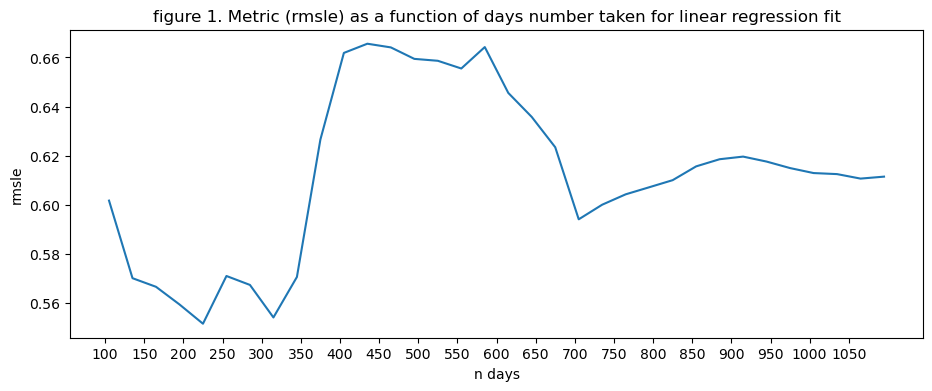

In [135]:
metrics_figure(metrics_df)  

We can see the min below 0.56 in n days range 200 - 300. Then in range 350 - 400 there is a sharp jump from 0.56 to 0.66. 
Then slow decrease to local min near 700 to metric value below 0.6. It is a clear question why mertic jump after n days = 350. To answer the question consider family/store sales.

In [144]:
store_list    = train_data.store_nbr.unique().tolist()
family_list   = train_data.family   .unique().tolist()
n_store_temp  =  len(store_list )
n_family_temp =  len(family_list)
print(f"We have {n_store_temp} shopes and {n_family_temp} product's family in total {n_store_temp*n_family_temp} combunation.\nTo select stores and familyes (or/and its combination) with potential sharp changes in sales patern\nlet us culculate standard divation.")

We have 54 shopes and 33 product's family in total 1782 combunation.
To select stores and familyes (or/and its combination) with potential sharp changes in sales patern
let us culculate standard divation.


Look at stores with biggest std/mean

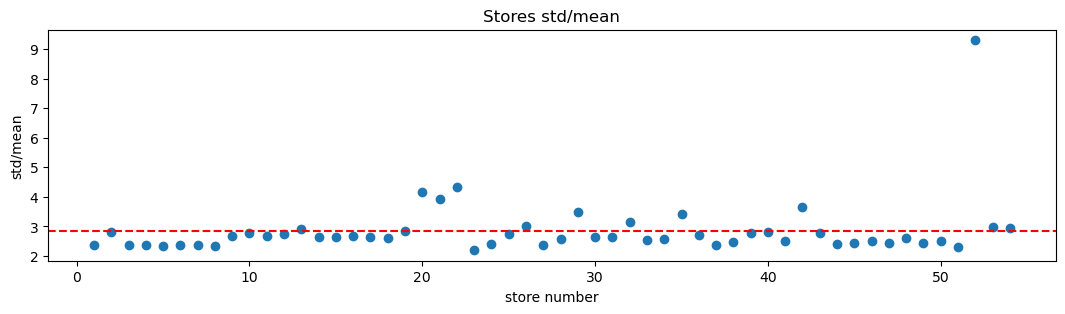

In [145]:
# Max std/mean for store 
df = train_plus_test_plus[['date','store_nbr','sales']]
mean_store = df.groupby(['store_nbr'])['sales'].mean()
std_store  = df.groupby(['store_nbr'])['sales'].std()
std_div_mean_store = ((std_store/mean_store)
                             .to_frame()
                             .sort_values(by = 'sales', ascending= False)
                             .reset_index())
                             #.head(10))
stores   = std_div_mean_store.store_nbr.to_list()
std_mean = std_div_mean_store.sales    .to_list()
mean_std_div_mean = std_div_mean_store.sales.mean()
#print(std_div_mean_store)
plt.figure(figsize = (13,3))
#plt.scatter(stores, std_mean)
plt.scatter(std_div_mean_store.store_nbr, std_div_mean_store.sales)
plt.axhline(y = mean_std_div_mean, color='r', linestyle='--', label='Your Horizontal Line')
#plt.xticks(stores)
plt.xlabel('store number')
plt.ylabel('std/mean')
plt.title('Stores std/mean')
plt.show()

Look at sales for worst stores

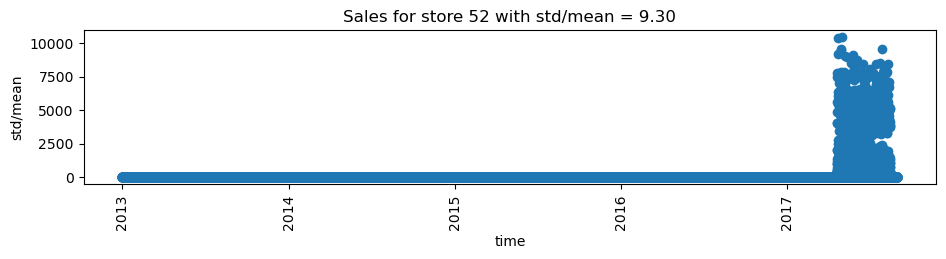

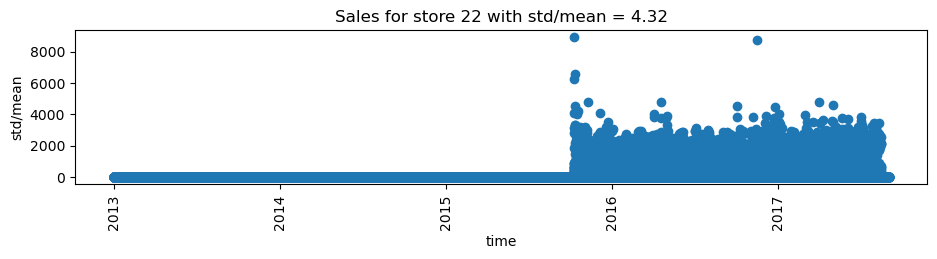

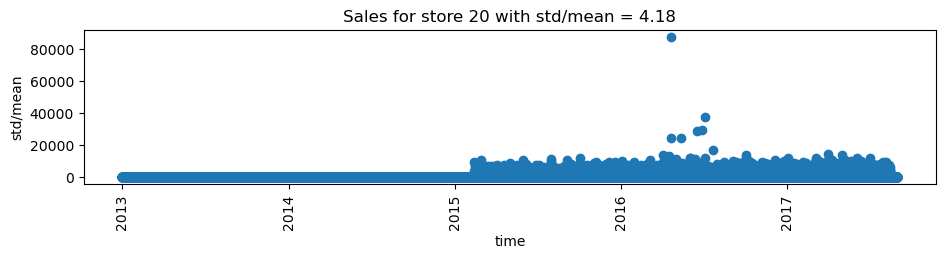

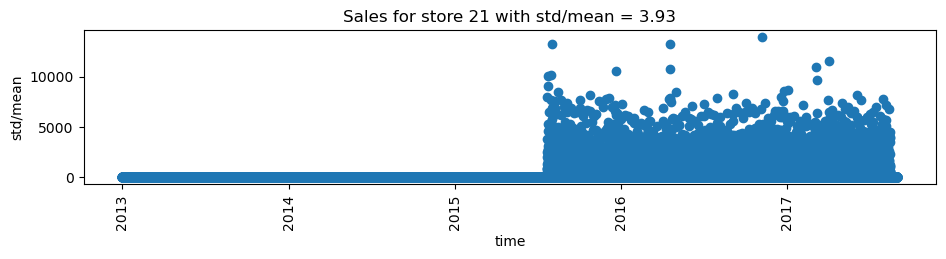

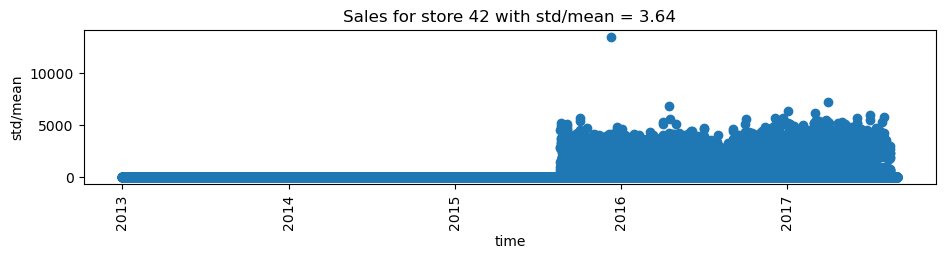

In [139]:
n_stores       = 5
to_bould_graph = stores[0:n_stores]
for i in to_bould_graph:
    df_for_graph = train_plus_test_plus.loc[train_plus_test_plus.store_nbr == i][['date','sales']]
    stdmean = std_div_mean_store.loc[std_div_mean_store.store_nbr == i].sales.values[0]
    plt.figure(figsize = (11,2))
    plt.scatter(df_for_graph.date.dt.to_timestamp(), df_for_graph.sales)
    plt.xlabel('time')
    plt.xticks(rotation = 'vertical')
    plt.ylabel('std/mean')
    plt.title(f'Sales for store {i} with std/mean = {stdmean:.2f}')
    plt.show()

The pictures above show why:
    1. linear regression faced problems with forecast
    2. it is very important to define time interval for train set 

Look at families with biggest std/mean

In [148]:
def select_data_for_calc_std(df,ndays):
    """
    the function selects the data from training dataset for chosen numbers of days, 
    not indcude val dataset,
    days from the end of the training dataset
    """
    n_from = N_train_data - N_val - ndays*n_stores_in_dataset*n_families_in_dataset
    n_to   = N_train_data - N_val
    n_df   = df[['date','store_nbr','family','sales']].iloc[n_from:n_to,:]
    return n_df

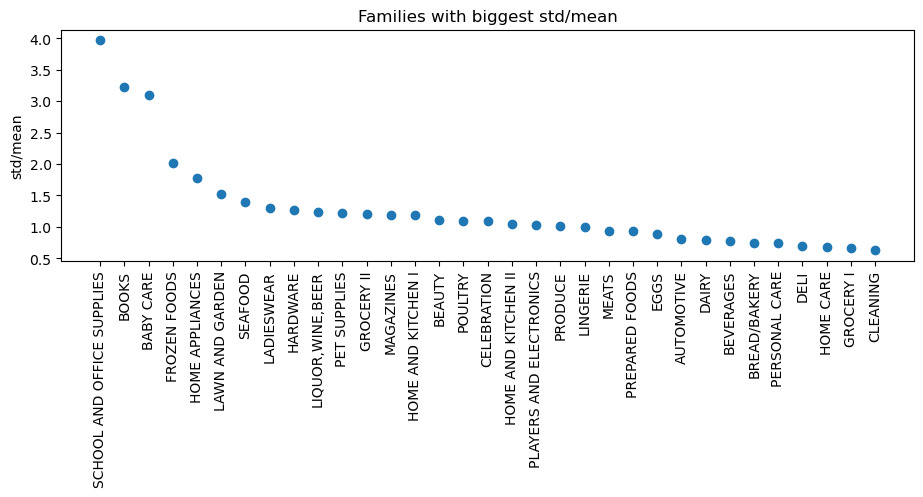

In [149]:
# Max std/mean for family 
df = select_data_for_calc_std(train_plus_test_plus,n)
df = df[['date','family','sales']]
mean_family = df.groupby(['family'])['sales'].mean()
std_family  = df.groupby(['family'])['sales'].std()
std_div_mean_family = ((std_family/mean_family)
                             .to_frame()
                             .sort_values(by = 'sales', ascending= False)
                             .reset_index())
                             #.head(10))
families = std_div_mean_family.family.to_list()
#std_div_mean_family.head(5)
plt.figure(figsize = (11,3))
plt.scatter(std_div_mean_family.family, std_div_mean_family.sales)
#plt.xlabel('store number')
plt.xticks(rotation = 'vertical')
plt.ylabel('std/mean')
plt.title('Families with biggest std/mean')
plt.show()

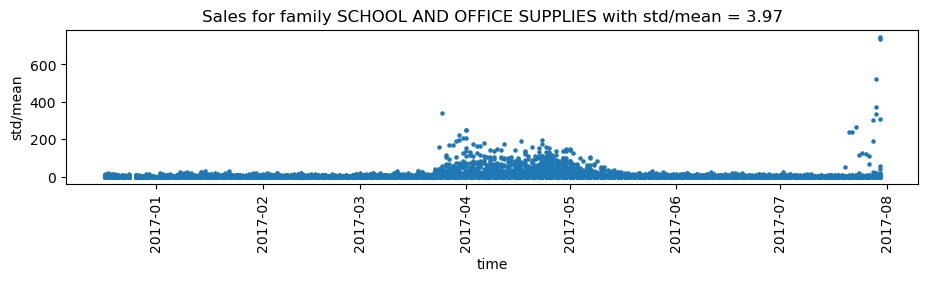

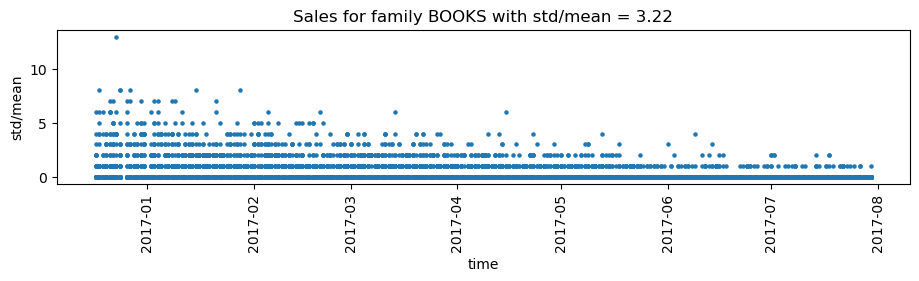

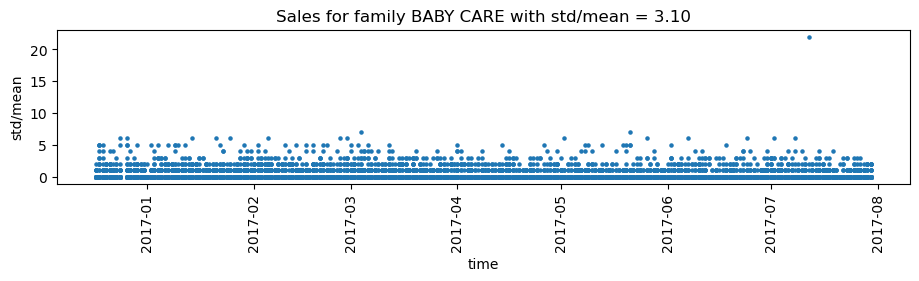

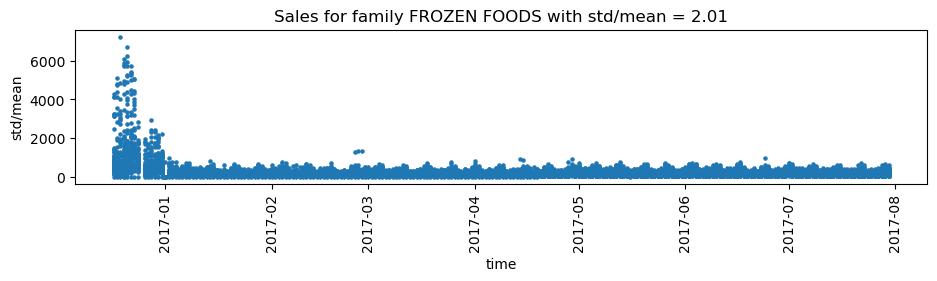

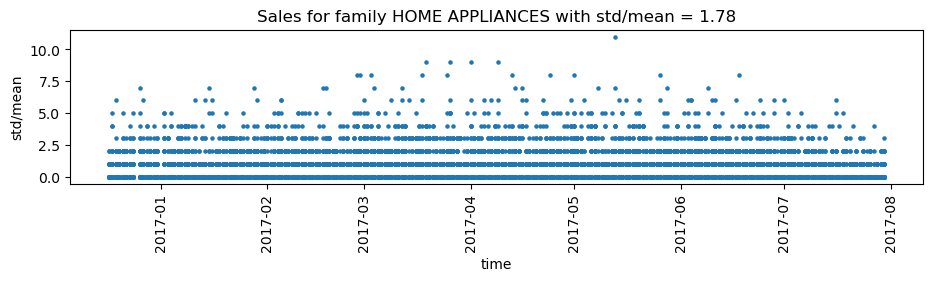

In [150]:
n_families       = 5
to_bould_graph = families[0:n_families]
df = select_data_for_calc_std(train_plus_test_plus,n)
for i in to_bould_graph:
    df_for_graph = df.loc[df.family == i][['date','sales']]
    stdmean      = std_div_mean_family.loc[std_div_mean_family.family == i].sales.values[0]
    plt.figure(figsize = (11,2))
    plt.scatter(df_for_graph.date.dt.to_timestamp(), df_for_graph.sales, s= 5)
    plt.xlabel('time')
    plt.xticks(rotation = 'vertical')
    plt.ylabel('std/mean')
    plt.title(f'Sales for family {i} with std/mean = {stdmean:.2f}')
    plt.show()

Look at store and family with biggest std/mean

In [151]:
# calculate metric for couple store and family
rmsle_val_list = []
s_list = []
f_list = []
val_dataset    = train_plus_test_plus.loc[val_id][['sales','store_nbr','family']]
val_predict    = (
                  pd.merge
                  (train_plus_test_plus[['id','date','store_nbr','family']],
                  val_p_temp,
                  on = ['date','store_nbr','family'],
                  how = 'inner')
                  )                                                                                      
#print(val_dataset)
for s in store_list:
    val_sales_s   = val_dataset.loc[val_dataset.store_nbr == s]
    val_predict_s = val_predict.loc[val_predict.store_nbr == s]
    for f in family_list: 
        sales_val      = val_sales_s  .loc[val_sales_s  .family == f].sales
        prediction_val = val_predict_s.loc[val_predict_s.family == f].sales.apply(lambda x : x if x > 0 else 0.000001)
        #print(sales_val.shape, val_predict_s.loc[val_predict_s.family == f].sales.shape, prediction_val.shape, s,f)
        rmsle  = mean_squared_log_error(sales_val,prediction_val, squared = False)
        rmsle_val_list.append(rmsle)
        s_list.append(s)
        f_list.append(f)
rmsle_val_df = pd.DataFrame({'store_nbr':s_list,'family':f_list, 'rmsle':rmsle_val_list})
rmsle_val_df.sort_values(by = 'rmsle', ascending= False, inplace = True)

In [ ]:
rmsle_val_df.shape

In [152]:
# Max std/mean for couple store family
def calculate_std_mean(ndays):
    """
    calculate std/mean for chosen amount of days
    return stats and stats_more_1: 
    stats.columns = ['means','std','std_div_mean']
    stats_more_1 = stats where mean > 1 to avoid very small sales series with big std/mean
    
    """
    n_df = select_data_for_calc_std(train_plus_test_plus,n)
    mean_store_family = df.groupby(['store_nbr','family'])['sales'].mean()
    std_store_family  = df.groupby(['store_nbr','family'])['sales'].std()
    std_div_mean_store_family = ((std_store_family/mean_store_family)
                             .to_frame())
    stats = pd.concat([mean_store_family,std_store_family,std_div_mean_store_family], axis = 1)
    stats.columns = ['means','std','std_div_mean']
    stats = stats.sort_values('std_div_mean', ascending = False)
    stats_more_1 = stats.loc[stats.means > 1].sort_values('std_div_mean', ascending = False)
    return stats,stats_more_1

In [153]:
stats,stats_more_1 = calculate_std_mean(n)

In [154]:
stats.shape

(1782, 3)

In [155]:
n_sample_from_the_end = 400
n_s = train_data.shape[0] - n_sample_from_the_end
def select_data_for_graph(df,fw,sw,n):
    sales_s_f = (df.loc[df.family    == fw]
                   .loc[df.store_nbr == sw]
                   .iloc[-n:,:][['date','sales']])
    return sales_s_f
def show_graph(sales_s_f, rmsle):
    plt.rcParams['lines.markersize'] = 3
    plt.figure (figsize=(11,2))
    #plt.scatter(train_plus_test_plus.index,train_plus_test_plus.sales)
    date_object = pd.to_datetime(sales_s_f.date.apply(lambda x: x.strftime('%Y-%m-%d')))
    plt.gca().xaxis.set_major_locator  (mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.scatter(date_object, sales_s_f.sales)
    plt.xticks(rotation =  'vertical')
    plt.legend (['sales'])
    plt.title  (f'Given Sales for store {sw} and family {fw} with rmsle = {rmsle:.2f}')
    #plt.show()

In [156]:
nsf = 10
s_l = stats.reset_index().iloc[0:nsf].store_nbr.to_list()
f_l = stats.reset_index().iloc[0:nsf].family   .to_list()
sf = zip(s_l,f_l)

In [157]:
stats_with_rmsle = pd.merge(stats.reset_index(),rmsle_val_df, on = ['store_nbr', 'family'], how = 'inner')

In [158]:
stats_with_rmsle .head(3)

,store_nbr,family,means,std,std_div_mean,rmsle
0,6,BOOKS,0.004444,0.066667,15.000000,0.009632
1,54,BABY CARE,0.022222,0.220479,9.921567,0.010309
2,26,BOOKS,0.013333,0.114953,8.621506,0.024323


In [159]:
stats_with_rmsle[['rmsle','std']].corr()

,rmsle,std
rmsle,1.000000,-0.216083
std,-0.216083,1.000000


In [160]:
stats_with_rmsle[['rmsle','std_div_mean']].corr()

,rmsle,std_div_mean
rmsle,1.000000,0.114408
std_div_mean,0.114408,1.000000


In [161]:
check_df = select_data_for_calc_std(train_plus_test_plus,n)
check_df.shape 

(400950, 4)

In [162]:
check_df.date.unique()

<PeriodArray>
['2016-12-17', '2016-12-18', '2016-12-19', '2016-12-20', '2016-12-21',
 '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-26', '2016-12-27',
 ...
 '2017-07-21', '2017-07-22', '2017-07-23', '2017-07-24', '2017-07-25',
 '2017-07-26', '2017-07-27', '2017-07-28', '2017-07-29', '2017-07-30']
Length: 225, dtype: period[D]

In [163]:
val_dates

[Period('2017-08-10', 'D'),
 Period('2017-08-05', 'D'),
 Period('2017-07-31', 'D'),
 Period('2017-08-01', 'D'),
 Period('2017-08-12', 'D'),
 Period('2017-08-13', 'D'),
 Period('2017-08-08', 'D'),
 Period('2017-08-14', 'D'),
 Period('2017-08-11', 'D'),
 Period('2017-08-06', 'D'),
 Period('2017-08-07', 'D'),
 Period('2017-08-02', 'D'),
 Period('2017-08-03', 'D'),
 Period('2017-08-09', 'D'),
 Period('2017-08-04', 'D'),
 Period('2017-08-15', 'D')]

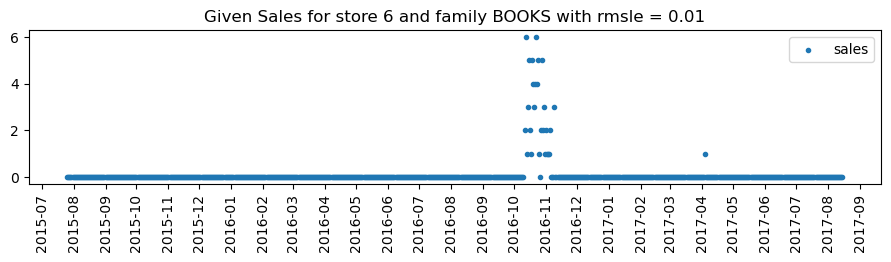

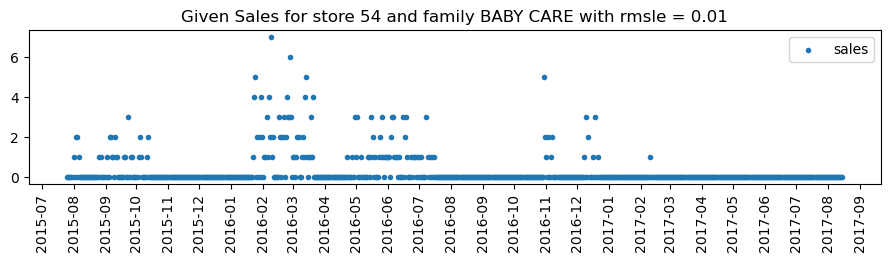

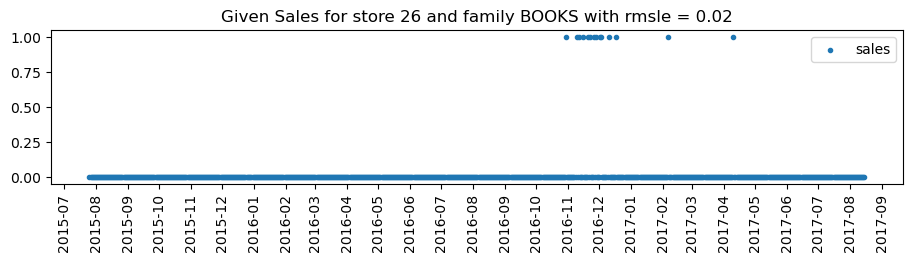

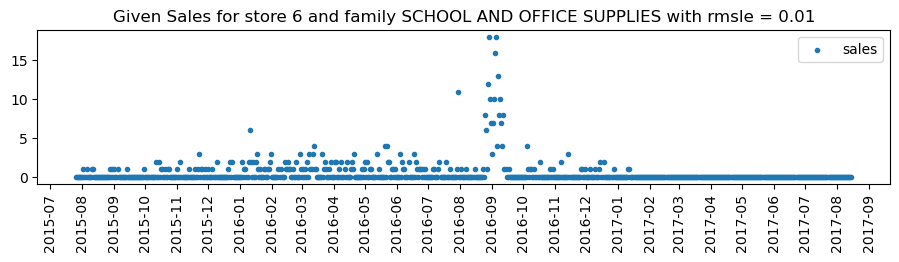

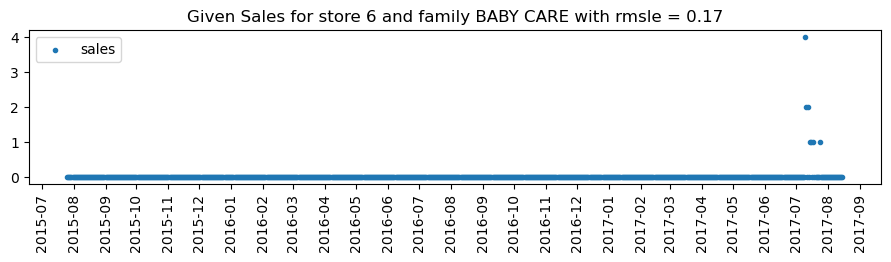

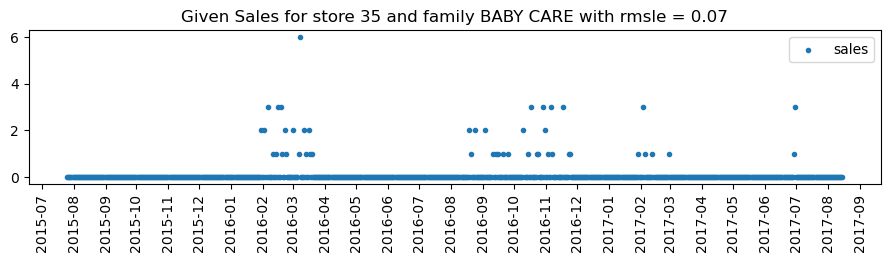

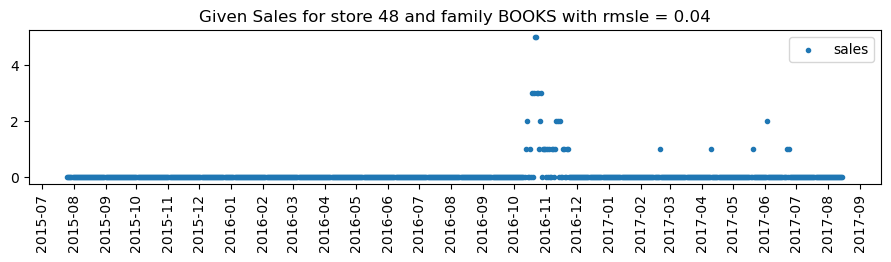

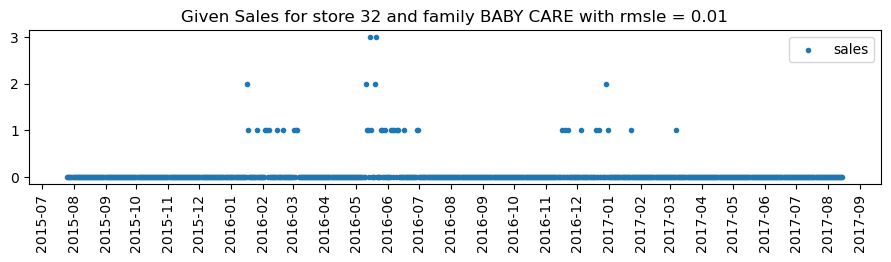

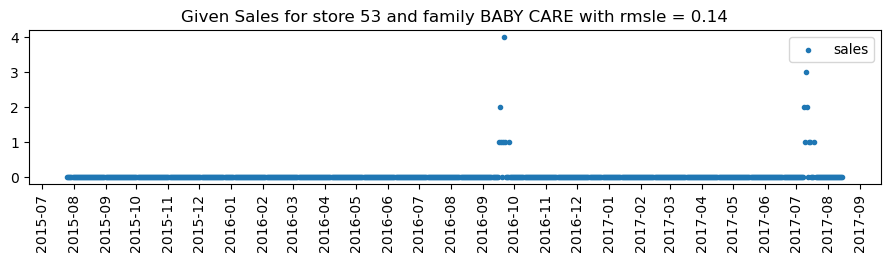

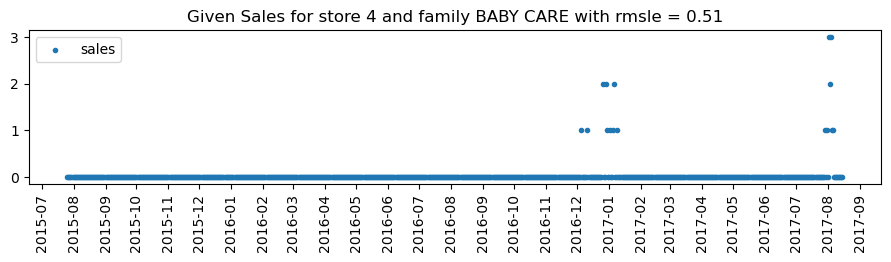

In [164]:
n_days_for_graph = 750
for sw,fw in sf:
    data_for_graph = select_data_for_graph(train_data,fw,sw,n_days_for_graph )
    rmsle_sf = rmsle_val_df.loc[rmsle_val_df.store_nbr == sw].loc[rmsle_val_df.family == fw].rmsle.iloc[0]
    show_graph(data_for_graph,rmsle_sf)
plt.show()

Look at store, family with worst metric

In [165]:
rmsle_val_df.head(5)

,store_nbr,family,rmsle
343,19,GROCERY II,1.837888
295,17,SCHOOL AND OFFICE SUPPLIES,1.691544
572,25,FROZEN FOODS,1.489475
1582,52,SCHOOL AND OFFICE SUPPLIES,1.472769
946,35,"LIQUOR,WINE,BEER",1.453921


Look at the sales patern for stores and families with worst rmsle metric

In [171]:
nsf = 7
s_l = rmsle_val_df.iloc[0:nsf].store_nbr.to_list()
f_l = rmsle_val_df.iloc[0:nsf].family   .to_list()
sf = zip(s_l,f_l)

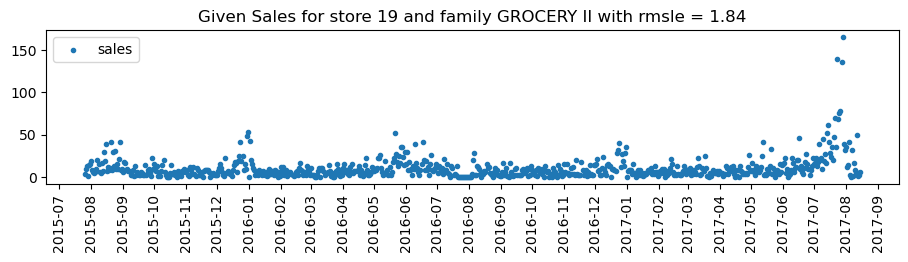

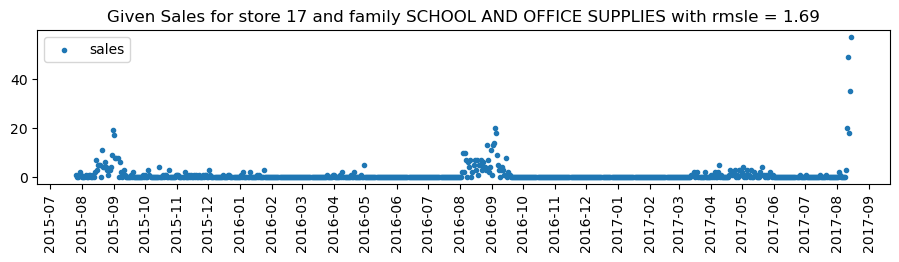

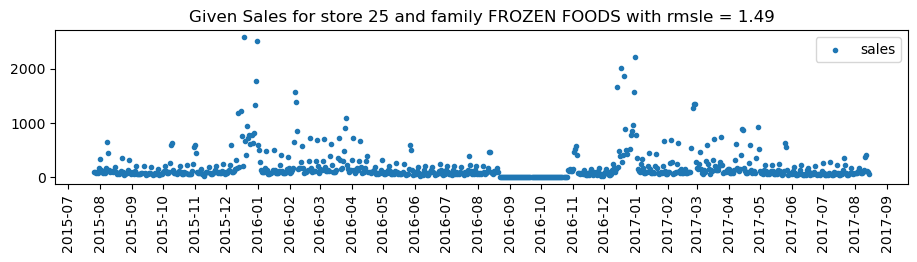

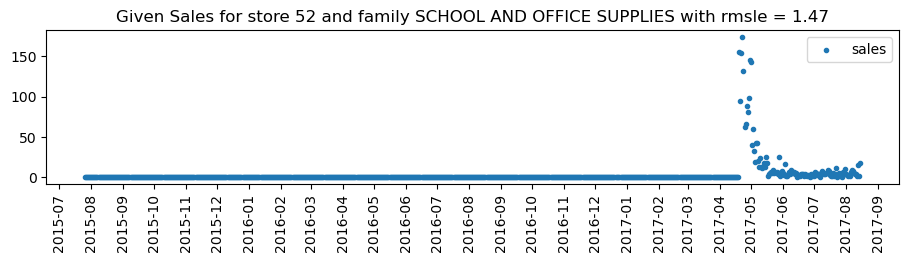

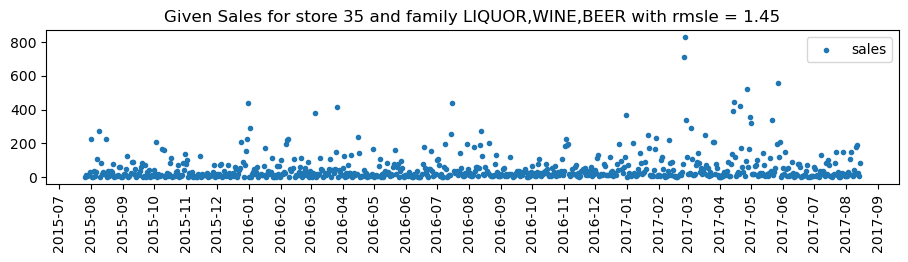

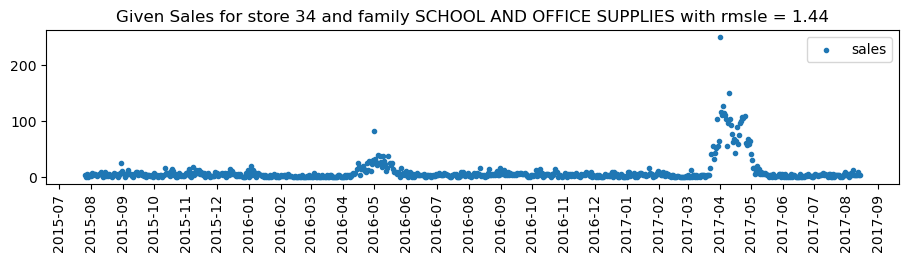

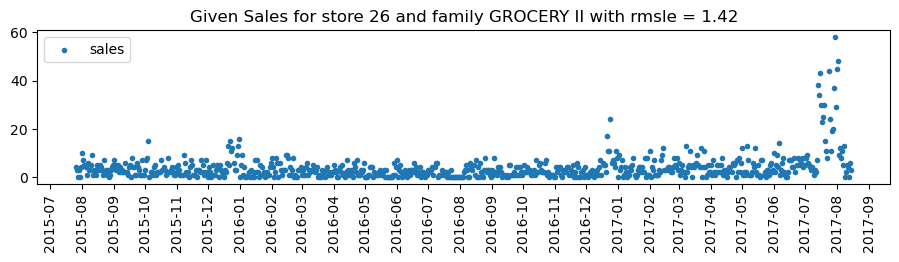

In [172]:
n_days_for_graph = 750
for sw,fw in sf:
    data_for_graph = select_data_for_graph(train_data,fw,sw,n_days_for_graph )
    rmsle = rmsle_val_df.loc[rmsle_val_df.store_nbr == sw].loc[rmsle_val_df.family == fw].rmsle.iloc[0]
    show_graph(data_for_graph,rmsle)
plt.show()

Figures for sture/family sales show that main problem for linear forecast is: 

1. Some stores were started on different dates (during train period).

2. Set of stores have started to trade some kinds of product family on different dates (during train period).

3. Sales have pikes probably connected with holidays